[nltk_data] Downloading package punkt to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing Luxury_Beauty...
Similarity score for rating 1 in Luxury_Beauty: 1.0
Similarity score for rating 2 in Luxury_Beauty: 1.0000000000000009
Similarity score for rating 3 in Luxury_Beauty: 0.9999999999999997
Similarity score for rating 4 in Luxury_Beauty: 1.0000000000000002
Similarity score for rating 5 in Luxury_Beauty: 0.9999999999999997
Most common words for rating 1 in Luxury_Beauty:
[('horribl', 1)]
Most common words for rating 2 in Luxury_Beauty:
[('advertis', 1), ('shave', 1), ('skin', 1), ('hairnot', 1), ('good', 1), ('qualitywil', 1), ('throw', 1), ('away', 1), ('go', 1), ('mack', 1)]
Most common words for rating 3 in Luxury_Beauty:
[('much', 4), ('product', 4), ('use', 3), ('scalp', 3), ('time', 2), ('suggest', 2), ('tool', 2), ('get', 2), ('appli', 2), ('area', 2)]
Most common words for rating 4 in Luxury_Beauty:
[('hair', 4), ('like', 2), ('dri', 2), ('realli', 1), ('product', 1), ('use', 1), ('wet', 1), ('itll', 1), ('littl', 1), ('bit', 1)]
Most common words for rat

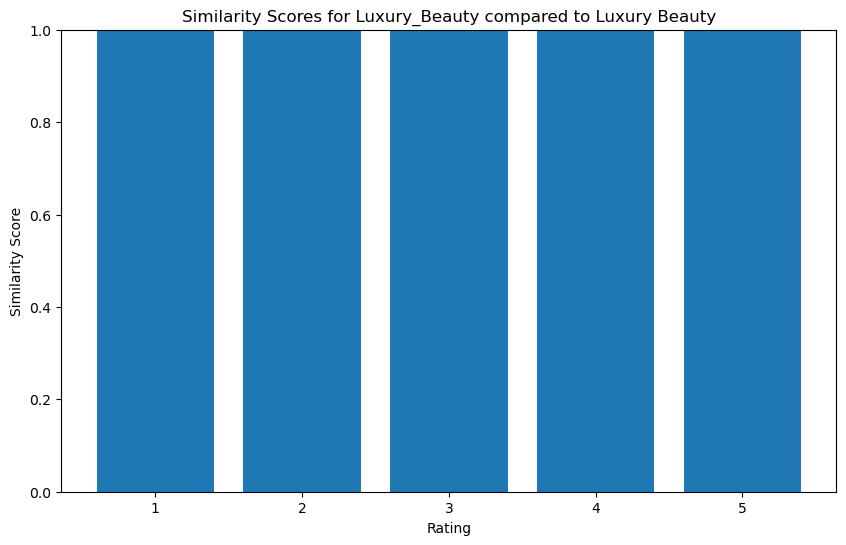

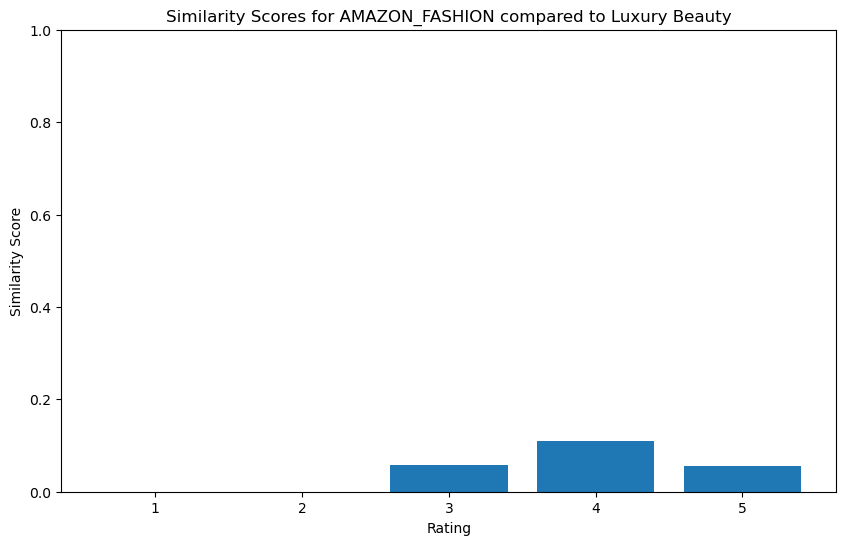

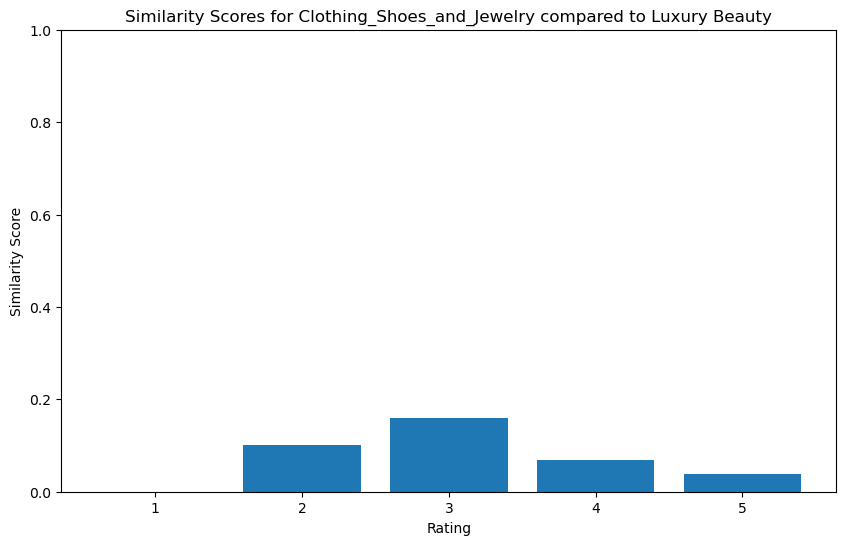

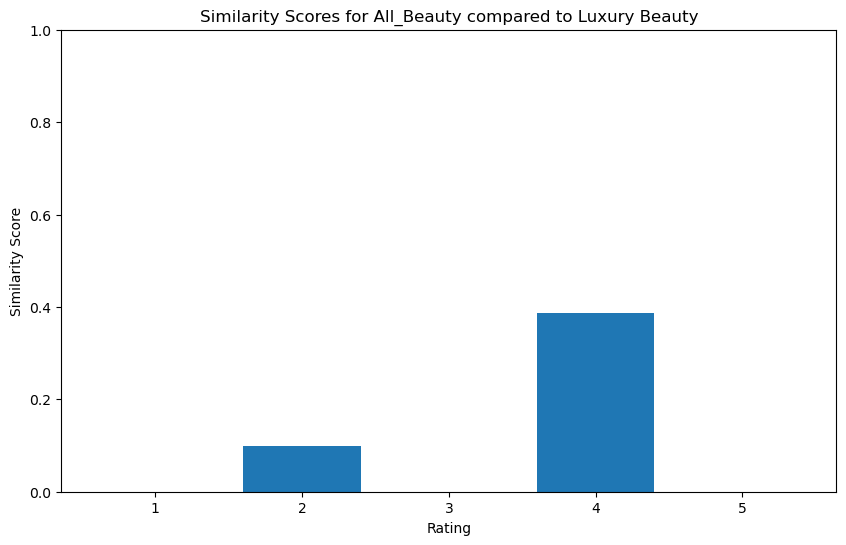

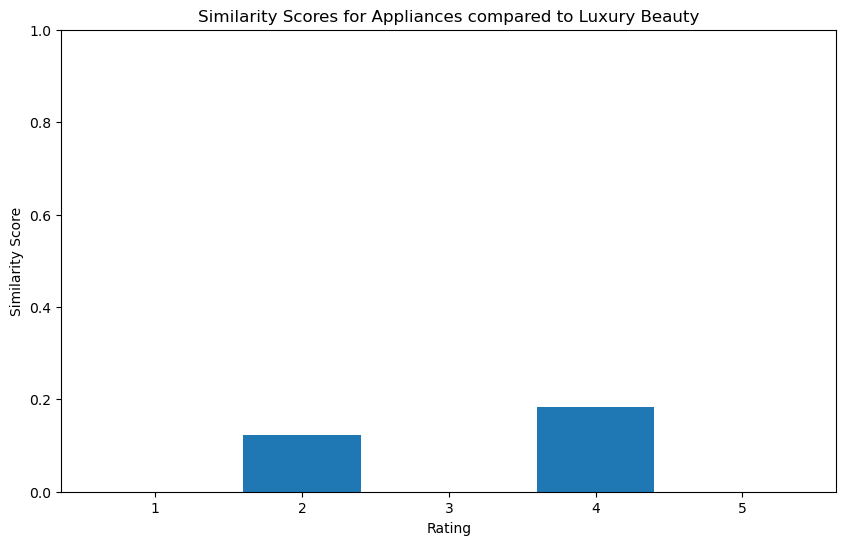

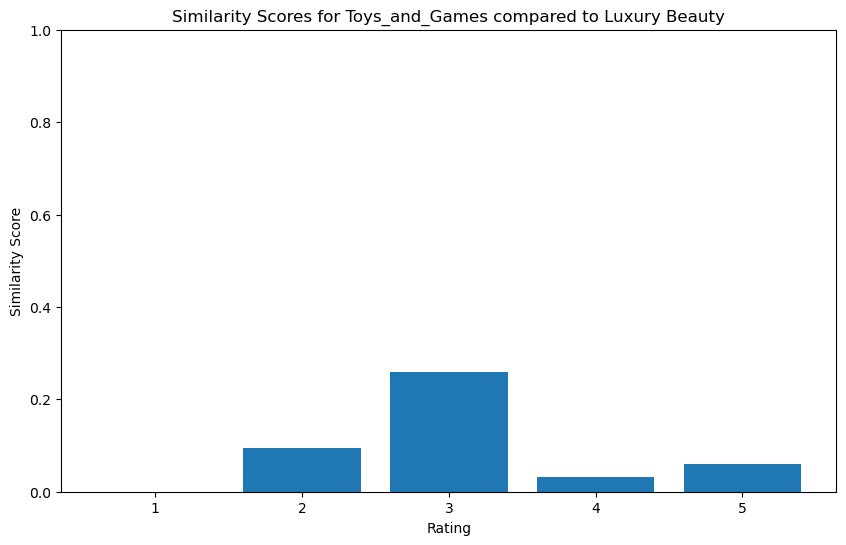

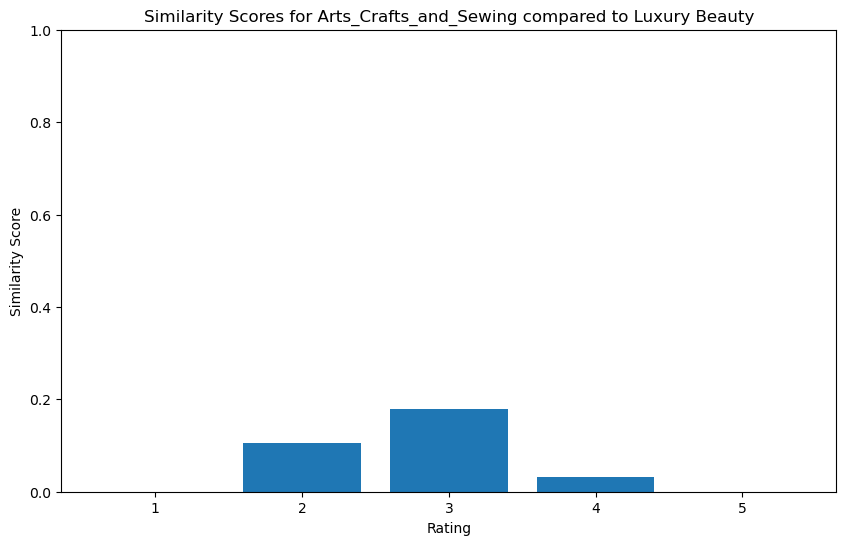

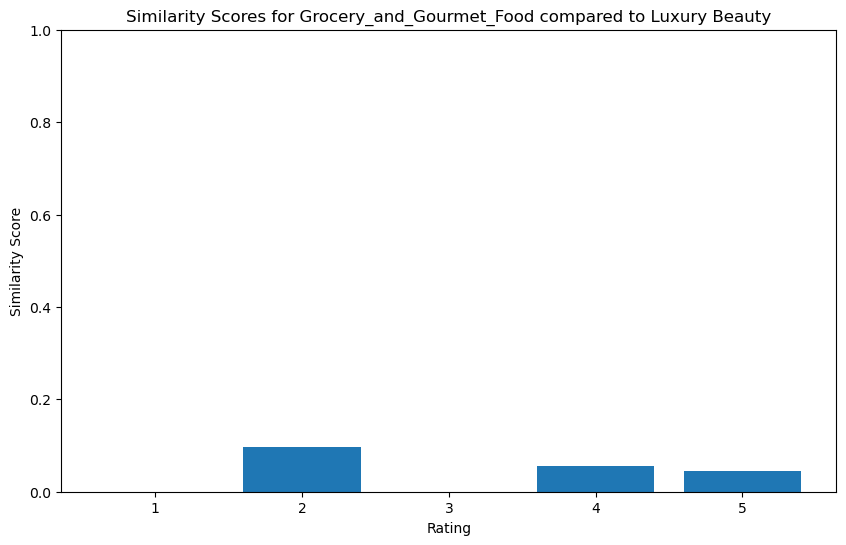

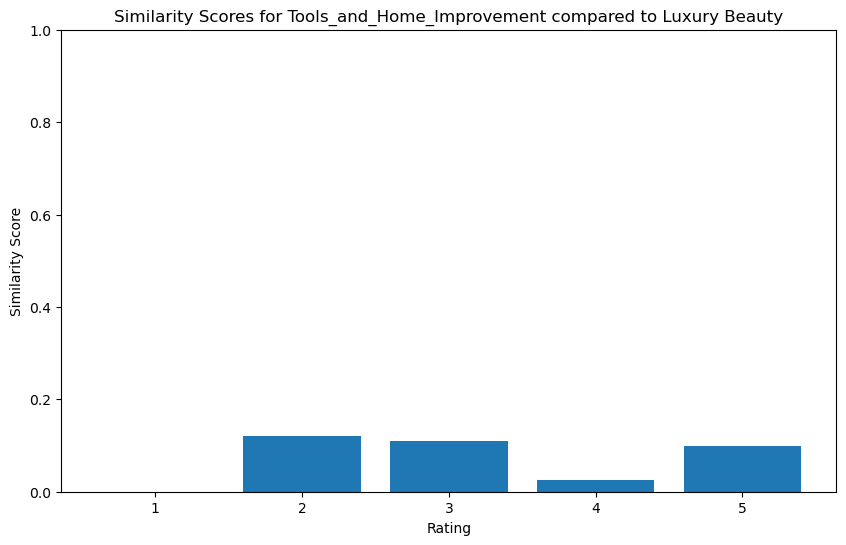

Processing complete.


In [17]:
import pandas as pd
import json
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
import matplotlib.pyplot as plt



# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


def extract_reviews(file_path, max_reviews_per_rating=1, random_state=42, chunksize=5000):
    """
    Extracts up to 'max_reviews_per_rating' reviews for each rating (1-5) from a given JSON file.

    Args:
    - file_path (str): Path to the JSON file.
    - max_reviews_per_rating (int): Maximum number of reviews to extract for each rating.
    - random_state (int): Random state for reproducibility.
    - chunksize (int): Number of records to read at a time (chunk size).

    Returns:
    - DataFrame: A DataFrame containing the extracted reviews and their ratings.
    """
    all_reviews = {rating: [] for rating in range(1, 6)}
    
    # Process the file in chunks
    reader = pd.read_json(file_path, lines=True, chunksize=chunksize)
    for chunk in reader:
        for _, row in chunk.iterrows():
            rating = int(row.get('overall', 0))
            review_text = row.get('reviewText', '')

            # Append review to the list for the corresponding rating
            if rating in all_reviews:
                all_reviews[rating].append(review_text)
    
    # Randomly sample reviews from each rating category
    random.seed(random_state)
    review_data = []
    for rating, texts in all_reviews.items():
        sampled_texts = random.sample(texts, min(max_reviews_per_rating, len(texts)))
        for text in sampled_texts:
            review_data.append({'rating': rating, 'review_text': text})

    return pd.DataFrame(review_data)



def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Tokenize and convert to lower case
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
     # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens



# Your categories dictionary
categories = {
    'Luxury_Beauty': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Luxury_Beauty.json',
    'AMAZON_FASHION': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/AMAZON_FASHION.json',
    'Clothing_Shoes_and_Jewelry': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Clothing_Shoes_and_Jewelry.json',
    'All_Beauty': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/All_Beauty.json',
    'Appliances': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Appliances.json',
    'Toys_and_Games': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Toys_and_Games.json',
    'Arts_Crafts_and_Sewing': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Arts_Crafts_and_Sewing.json',
    'Grocery_and_Gourmet_Food': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Grocery_and_Gourmet_Food.json',
    'Tools_and_Home_Improvement': '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Tools_and_Home_Improvement.json'
}

def calculate_similarity(target_reviews, other_reviews):
    """ Calculate the cosine similarity between two sets of reviews. """
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(target_reviews + other_reviews)
    target_vector = vectors[:len(target_reviews)]
    other_vector = vectors[len(target_reviews):]
    similarity = cosine_similarity(target_vector, other_vector)
    return np.mean(similarity)




# Initialize the dictionary to store similarity scores
similarity_scores = {category: [] for category in categories.keys()}

# Assuming 'Luxury_Beauty' is your target category
target_reviews_df = extract_reviews(categories['Luxury_Beauty'])

# Process each category
for category, file_path in categories.items():
    print(f"Processing {category}...")

    # Extract reviews
    reviews_df = extract_reviews(file_path)

    # Calculate similarity for each rating
    for rating in range(1, 6):
        target_rating_reviews = target_reviews_df[target_reviews_df['rating'] == rating]['review_text'].tolist()
        category_rating_reviews = reviews_df[reviews_df['rating'] == rating]['review_text'].tolist()

        if target_rating_reviews and category_rating_reviews:
            similarity_score = calculate_similarity(target_rating_reviews, category_rating_reviews)
            similarity_scores[category].append(similarity_score)
            print(f"Similarity score for rating {rating} in {category}: {similarity_score}")

    # Analyze most common words for each rating
    for rating in range(1, 6):
        rating_reviews = reviews_df[reviews_df['rating'] == rating]['review_text']
        all_words = []
        for review in rating_reviews:
            all_words.extend(clean_text(review))

        word_freq = Counter(all_words)
        most_common_words = word_freq.most_common(10)
        print(f"Most common words for rating {rating} in {category}:")
        print(most_common_words)

# Plotting the similarity scores
for category, scores in similarity_scores.items():
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 6), scores, tick_label=range(1, 6))
    plt.title(f"Similarity Scores for {category} compared to Luxury Beauty")
    plt.xlabel('Rating')
    plt.ylabel('Similarity Score')
    plt.ylim(0, 1)  # Cosine similarity ranges from 0 to 1
    plt.show()

print("Processing complete.")


